# Exploratory notebook for IMACLIM within MATMat-Trade

## Creating the MatMat-Trade model base on IMACLIM regions and sectors but on EXIOBASE 3 data

In [1]:
# make the necessary imports
import tqdm
import shutil
import warnings
import pandas as pd
import numpy as np
import multiprocessing


from main import Model,load_model
from src.utils import footprint_extractor,get_import_mean_stressor,get_total_imports_region,recal_stressor_per_region,get_total_imports_region,multi_footprints_extractor,save_footprints
from src.scenarios import DICT_SCENARIOS
from src.advance import extract_data
from src.figures import plot_sector_import_distrib,plot_sector_import_distrib_full
from src.stressors import GHG_STRESSOR_NAMES,GHG_AND_MATERIALS_PARAM,MATERIAL_STRESSOR_NAMES

In [ ]:
# for some reason saved model has issues with the names of regions so we rebuild the model each times


shutil.rmtree('data/models/2015__pxp__IMACLIM_format__ghg')

In [3]:


model = Model(aggregation_name="IMACLIM_format")

#ignore performace warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

Loading data... (may take a few minutes)
Data loaded successfully !


## Creating the scenarios based on IMACLIM scenarios and the projected changes 

In [4]:

scenario_list=["INDC","INDC2020_1000","INDC2030_1000","INDC2020_1600","INDC2020_400","INDC2030_1600","baseline"]

for scenario in tqdm.tqdm(scenario_list[:1]):
    # create 2050 version of each scenarios applying emissivity changes and then technological changes
    model.new_counterfactual("IMACLIM_all_2050_"+scenario, DICT_SCENARIOS["emissivity_IMACLIM"], year=2050,scenario=scenario)
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["technical_change_IMACLIM"], year=2050,scenario=scenario)
    # create the 2050 version based on production changes observed in IMACLIM (since we work on groos output, we need a reference to apply relative change : x_ref), with name new_name
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["production_change_IMACLIM"], year=2050,scenario="INDC",new_name="IMACLIM_all_prod_change_2050_"+scenario,x_ref=model.iot.x.sort_index())
    
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["consumption_change_imaclim"], year=2050,scenario="INDC",new_name="IMACLIM_all_cons_change_2050_"+scenario)

  0%|          | 0/1 [00:02<?, ?it/s]


KeyboardInterrupt: 

## Getting the emissions per scenario 

### Single process version, might be long to run 

In [ ]:

scenario_list=["INDC","INDC2020_1000","INDC2030_1000","INDC2020_1600","INDC2020_400","INDC2030_1600","baseline"]

start_year=pd.concat([ pd.concat([pd.DataFrame(footprint_extractor(model,region=region),index=[2015]).T  for region in model.regions],
                      keys=model.regions,
                      names=("regions","types")) for scenario in scenario_list],
          keys=scenario_list,
          names=("scenario","regions","types"))

Emissions=pd.concat([start_year for i in range(4)],axis=1,keys=["2015","2050","2050-Prod","2050-Cons"]).sort_index()
Emissions.columns=["2015","2050","2050-Prod","2050-Cons"]

production_based_emissions=pd. concat([ pd.concat([ model.iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2"]for i in range(4)],axis=1,keys=["2015","2050","2050-Prod","2050-Cons"]) for scenario in scenario_list],
                                        keys=scenario_list,
                                        names=("scenario","region","sector"),
                                        axis=0).sort_index()


for scenario in tqdm.tqdm(scenario_list):
    # create 2050 version of each scenarios applying emissivity changes and then technological changes
    model.new_counterfactual("IMACLIM_all_2050_"+scenario, DICT_SCENARIOS["emissivity_IMACLIM"], year=2050,scenario=scenario)
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["technical_change_IMACLIM"], year=2050,scenario=scenario)
    # create the 2050 version based on production changes observed in IMACLIM (since we work on groos output, we need a reference to apply relative change : x_ref), with name new_name
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["production_change_IMACLIM"], year=2050,scenario=scenario,new_name="IMACLIM_all_prod_change_2050_"+scenario,x_ref=model.iot.x.sort_index())
    
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["consumption_change_imaclim"], year=2050,scenario=scenario,new_name="IMACLIM_all_cons_change_2050_"+scenario)
    
    Emissions.loc[(scenario),"2050"]=pd.concat([pd.DataFrame(footprint_extractor(model.counterfactuals["IMACLIM_all_2050_"+scenario],region=region),index=[2050]).T  for region in model.regions],
                        keys=model.regions,
                        names=("regions","types")).sort_index().values
    
    Emissions.loc[(scenario),"2050-Prod"]=pd.concat([pd.DataFrame(footprint_extractor(model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario],region=region),index=[2050]).T  for region in model.regions],
                        keys=model.regions,
                        names=("regions","types")).sort_index().values
    
    Emissions.loc[(scenario),"2050-Cons"]=pd.concat([pd.DataFrame(footprint_extractor(model.counterfactuals["IMACLIM_all_cons_change_2050_"+scenario],region=region),index=[2050]).T  for region in model.regions],
                        keys=model.regions,
                        names=("regions","types")).sort_index().values
    
    production_based_emissions.loc[(scenario),"2050-Cons"]=model.counterfactuals["IMACLIM_all_cons_change_2050_"+scenario].iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2"].sort_index().values
    
    production_based_emissions.loc[(scenario),"2050-Prod"]=model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario].iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2"].sort_index().values
    
    production_based_emissions.loc[(scenario),"2050"]=model.counterfactuals["IMACLIM_all_2050_"+scenario].iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2"].sort_index().values
    
    del(model.counterfactuals["IMACLIM_all_2050_"+scenario])
    del(model.counterfactuals["IMACLIM_all_cons_change_2050_"+scenario])
    del(model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario])
    
    

### Multiple Process versio, should be faster

In [6]:

NBR_PROCESS=4

scenario_list=["INDC","INDC2020_1000","INDC2030_1000","INDC2020_1600","INDC2020_400","INDC2030_1600","baseline"]

start_year=pd.concat([ pd.concat([pd.DataFrame(footprint_extractor(model,region=region),index=[2015]).T  for region in model.regions],
                      keys=model.regions,
                      names=("regions","types")) for scenario in scenario_list],
          keys=scenario_list,
          names=("scenario","regions","types"))

Emissions=pd.concat([start_year for i in range(4)],axis=1,keys=["2015","2050","2050-Prod","2050-Cons"]).sort_index()
Emissions.columns=["2015","2050","2050-Prod","2050-Cons"]

production_based_emissions=pd. concat([ pd.concat([ model.iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2 - combustion"]for i in range(4)],axis=1,keys=["2015","2050","2050-Prod","2050-Cons"]) for scenario in scenario_list],
                                        keys=scenario_list,
                                        names=("scenario","region","sector"),
                                        axis=0).sort_index()


def task(scenario):
    model.new_counterfactual("IMACLIM_all_2050_"+scenario, DICT_SCENARIOS["emissivity_IMACLIM"], year=2050,scenario=scenario)
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["technical_change_IMACLIM"], year=2050,scenario=scenario)
    # create the 2050 version based on production changes observed in IMACLIM (since we work on groos output, we need a reference to apply relative change : x_ref), with name new_name
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["production_change_IMACLIM"], year=2050,scenario=scenario,new_name="IMACLIM_all_prod_change_2050_"+scenario,x_ref=model.iot.x.sort_index())
    
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["consumption_change_imaclim"], year=2050,scenario=scenario,new_name="IMACLIM_all_cons_change_2050_"+scenario)
    
    ret1=pd.concat([pd.DataFrame(footprint_extractor(model.counterfactuals["IMACLIM_all_2050_"+scenario],region=region),index=[2050]).T  for region in model.regions],
                        keys=model.regions,
                        names=("regions","types")).sort_index().values
    
    ret2=pd.concat([pd.DataFrame(footprint_extractor(model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario],region=region),index=[2050]).T  for region in model.regions],
                        keys=model.regions,
                        names=("regions","types")).sort_index().values
    
    ret3=pd.concat([pd.DataFrame(footprint_extractor(model.counterfactuals["IMACLIM_all_cons_change_2050_"+scenario],region=region),index=[2050]).T  for region in model.regions],
                        keys=model.regions,
                        names=("regions","types")).sort_index().values
    
    ret4=model.counterfactuals["IMACLIM_all_cons_change_2050_"+scenario].iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2 - combustion"].sort_index().values
    
    ret5=model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario].iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2 - combustion"].sort_index().values
    
    ret6=model.counterfactuals["IMACLIM_all_2050_"+scenario].iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2 - combustion"].sort_index().values
    
    del(model.counterfactuals["IMACLIM_all_2050_"+scenario])
    del(model.counterfactuals["IMACLIM_all_cons_change_2050_"+scenario])
    del(model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario])
    
    return ret1,ret2,ret3,ret4,ret5,ret6


pool = multiprocessing.Pool(processes=NBR_PROCESS)
result_list=pool.map(task,scenario_list)

for i in range(len(scenario_list)):
    scenario=scenario_list[i]
    Emissions.loc[(scenario),"2050"],Emissions.loc[(scenario),"2050-Prod"],Emissions.loc[(scenario),"2050-Cons"],production_based_emissions.loc[(scenario),"2050-Cons"],production_based_emissions.loc[(scenario),"2050-Prod"],production_based_emissions.loc[(scenario),"2050"]=result_list[i]
        
    

Problems on sums of columns  {('AFR', 'Terrestrial transport'): MultiIndex([('AFR', 'Elec')],
           names=['region', 'sector']), ('MDE', 'Terrestrial transport'): MultiIndex([('MDE', 'Elec')],
           names=['region', 'sector']), ('RAL', 'Terrestrial transport'): MultiIndex([('RAL', 'Elec')],
           names=['region', 'sector'])}
Problems on sums of columns  {('AFR', 'Terrestrial transport'): MultiIndex([('AFR', 'Elec'),
            ('EUR', 'Elec')],
           names=['region', 'sector']), ('MDE', 'Terrestrial transport'): MultiIndex([('MDE', 'Elec')],
           names=['region', 'sector']), ('RAL', 'Terrestrial transport'): MultiIndex([('RAL', 'Elec')],
           names=['region', 'sector'])}
Problems on sums of columns  {('AFR', 'Terrestrial transport'): MultiIndex([('AFR', 'Elec')],
           names=['region', 'sector']), ('MDE', 'Terrestrial transport'): MultiIndex([('MDE', 'Elec')],
           names=['region', 'sector']), ('RAL', 'Terrestrial transport'): MultiIndex([('R

## Exploring the results

In [7]:
#adding IMACLIM direct emissions to the df
IMACLIM_emissions=extract_data(aggregation="IMACLIM_format")[6]

production_based_emissions["2050-IMACLIM"]=IMACLIM_emissions.drop("World",level=1)[2050].rename_axis(index=str.lower)*1e9
production_based_emissions["2015-IMACLIM"]=IMACLIM_emissions.drop("World",level=1)[2015].rename_axis(index=str.lower)*1e9

In [8]:
diff_rapport =((production_based_emissions["2050-IMACLIM"]/production_based_emissions["2015-IMACLIM"])-(production_based_emissions["2050-Prod"]/production_based_emissions["2015"]))

for scenario in scenario_list:
    print(scenario,diff_rapport.loc[scenario].max())

INDC -0.00013934485218389248
INDC2020_1000 -0.0003276979823503834
INDC2030_1000 -0.00037101368998671
INDC2020_1600 -0.0004776521976939535
INDC2020_400 -6.822528301587971e-05
INDC2030_1600 -0.00030601870675950327
baseline -0.00040758794010420374


In [9]:
Relative_error_2015=production_based_emissions.groupby(["scenario","region","sector"]).sum().loc["baseline"] 
Relative_error_2015=(Relative_error_2015["2015"]-Relative_error_2015["2015-IMACLIM"])/np.max([Relative_error_2015["2015"],Relative_error_2015["2015-IMACLIM"]],axis=0)
Relative_error_2015=Relative_error_2015*100
pd.concat([Relative_error_2015.loc[region] for region in Relative_error_2015.index.get_level_values("region").unique()],keys=Relative_error_2015.index.get_level_values("region").unique(),axis=1)

region,AFR,BRA,CAN,CHN,CIS,EUR,IND,JAN,MDE,RAL,RAS,USA
sector,,,,,,,,,,,,
Agriculture,-51.816572,-15.701008,11.178873,-49.972742,-79.250130,-15.293091,33.024779,-79.025188,-64.793266,-23.903528,25.993297,-10.790350
Air,-45.371885,-22.186058,12.026622,71.750897,-2.508423,22.239882,46.981273,-44.709538,47.311707,-67.793709,38.894410,-7.363546
Coal,36.384218,43.351854,-88.326434,4.551393,-52.581795,-51.686621,96.477606,-35.200343,100.000000,100.000000,99.599996,-67.145126
Construction,61.881947,98.301694,62.704530,88.132228,38.973969,89.920362,91.211247,32.869386,56.161626,96.946692,91.685658,78.316846
Elec,-39.143883,72.813771,-61.752687,38.125084,-96.831505,-56.272538,27.299278,-32.720686,15.987074,-21.769088,5.532301,-39.344545
Gas,49.862377,81.877660,8.400798,97.880386,4.630082,87.338991,68.912723,100.000000,-13.884805,-2.750222,49.480106,71.617183
Industry,-46.905764,3.454600,-53.631422,21.681645,-72.993368,-32.036645,-11.448268,-61.345385,36.645702,7.997643,7.809473,-54.594166
Liquid fuels,-91.659408,-76.416717,-38.014303,-44.130341,-55.236263,-77.632867,-2.684573,-82.068727,100.000000,100.000000,-61.479094,99.869401
Maritime,-89.679597,-69.921130,46.180283,70.196181,100.000000,41.035336,93.972451,40.129431,-24.899951,-70.254840,-23.664139,-42.914006


In [10]:
Relative_error_2015=production_based_emissions.groupby(["scenario","region","sector"]).sum().loc["baseline"] 
Relative_error_2015=(Relative_error_2015["2050-Prod"]-Relative_error_2015["2050-IMACLIM"])/np.max([Relative_error_2015["2050-Prod"],Relative_error_2015["2050-IMACLIM"]],axis=0)
Relative_error_2015=Relative_error_2015*100
pd.concat([Relative_error_2015.loc[region] for region in Relative_error_2015.index.get_level_values("region").unique()],keys=Relative_error_2015.index.get_level_values("region").unique(),axis=1)

region,AFR,BRA,CAN,CHN,CIS,EUR,IND,JAN,MDE,RAL,RAS,USA
sector,,,,,,,,,,,,
Agriculture,-51.656945,-15.266783,11.504655,-49.431557,-79.175735,-15.054691,33.246161,-78.939427,-64.693257,-23.560435,26.220545,-10.512430
Air,-45.210652,-21.524009,12.070326,81.292785,-2.120032,22.432858,47.484319,-44.655635,47.490449,-67.660621,39.072746,-7.275502
Coal,72.805685,67.331253,-72.494727,42.191572,-50.648569,-50.612082,99.198178,-32.563916,100.000000,100.000000,99.746911,-65.381141
Construction,61.900718,98.312907,62.714684,88.138614,39.013063,89.931354,91.237607,32.927130,56.183580,96.957309,91.707537,78.333637
Elec,-38.618422,82.936624,-61.340095,52.834612,-96.819542,-55.683932,27.820876,-32.451852,25.486279,20.096951,6.351936,-39.274913
Gas,81.736783,95.122844,55.238829,98.430383,7.649642,93.508416,94.419090,100.000000,-10.635473,24.754650,49.843837,80.346227
Industry,-46.813749,4.063369,-53.488318,22.768406,-72.885539,-31.725858,-10.731620,-61.102874,36.888833,8.376190,8.157572,-54.454310
Liquid fuels,-91.569440,-59.810837,-37.784950,-22.765704,-53.194232,-77.404329,9.750898,-80.356232,100.000000,100.000000,-54.909713,99.871180
Maritime,-89.657764,-65.271134,46.508416,70.646569,100.000000,43.329437,94.065216,40.845421,-23.848784,-69.349829,-22.670078,-42.754144


In [11]:
Relative_error_2015=production_based_emissions.groupby(["scenario","region"]).sum().loc["baseline"]
Relative_error_2015_ratio=(Relative_error_2015["2015"]-Relative_error_2015["2015-IMACLIM"])/np.max([Relative_error_2015["2015"],Relative_error_2015["2015-IMACLIM"]],axis=0)
Relative_error_2015_ratio=Relative_error_2015_ratio*100
pd.DataFrame(Relative_error_2015_ratio)

,0
region,
AFR,-46.954518
BRA,-0.561951
CAN,-22.995197
CHN,36.267118
CIS,-59.025546
EUR,-20.285232
IND,21.172125
JAN,-40.775450
MDE,15.702620


In [10]:
Relative_error_2015["2015"]+model.iot.stressor_extension.F_Y.sum(axis=1,level=0).loc["CO2"]

region
AFR    1.075643e+12
BRA    4.973495e+11
CAN    5.678739e+11
CHN    9.929628e+12
CIS    1.475975e+12
EUR    4.548643e+12
IND    2.118380e+12
JAN    1.628660e+12
MDE    2.189486e+12
RAL    1.286805e+12
RAS    3.212389e+12
USA    5.145479e+12
dtype: float64

In [11]:
import src.advance
final_data_ratio,final_technical_coef,Link_country,Link,Production_volumes,total_consumption,direct_emissions=src.advance.extract_data("IMACLIM_format")

### Comparing Consumption direct emission

In [12]:
import src.advance
conso=src.advance.exctract_consumption_emission("IMACLIM_format")

/home/ubuntu/miniforge3/envs/MatMat-Trade-env/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [15]:
model_base_year_CO2_conso=model.iot.stressor_extension.F_Y.groupby("region",axis=1).sum().loc["CO2 - combustion"]
IMACLIM_base_year_CO2_conso=conso.groupby(["Scenario","Region"]).sum().loc["baseline",2015]*1e9
comparison=pd.DataFrame([model_base_year_CO2_conso,IMACLIM_base_year_CO2_conso]).T
comparison.rename(columns={"CO2 - combustion":"MRIO",2015:"IMACLIM"},inplace=True)
comparison.loc["World","MRIO"]=comparison.loc[:,"MRIO"].fillna(0).sum()
comparison

,MRIO,IMACLIM
AFR,3.122832e+11,3.058000e+11
BRA,8.498662e+10,1.121000e+11
CAN,1.266648e+11,1.297600e+11
CHN,4.574793e+11,5.429000e+11
CIS,2.479844e+11,5.006000e+11
EUR,9.358370e+11,1.360400e+12
IND,2.191543e+11,1.737400e+11
JAN,2.213855e+11,5.126000e+11
MDE,3.301295e+11,3.148000e+11
RAL,2.712905e+11,3.603000e+11


In [14]:
residential=conso.loc[("INDC",slice(None),"Residential"),2015]*1e9
residential.drop("World",level=1,inplace=True)

In [15]:
residential

Scenario  Region  Variable   
INDC      USA     Residential    3.680000e+11
          CAN     Residential    4.539000e+10
          EUR     Residential    5.168000e+11
          JAN     Residential    1.056000e+11
          CIS     Residential    3.436000e+11
          CHN     Residential    4.092000e+11
          IND     Residential    1.220000e+11
          BRA     Residential    2.538000e+10
          MDE     Residential    1.927000e+11
          AFR     Residential    1.121000e+11
          RAS     Residential    1.044000e+11
          RAL     Residential    1.046000e+11
Name: 2015, dtype: float64

### IMACLIM2

In [16]:
imaclim_2=pd.read_excel("../Data/IMACLIM/IMACLIM2.0/IMACLIM_navigate_outputs_NAV_NPi_Default.xlsx",sheet_name="data",index_col=[1,2,3]).drop(columns=["Unit","Model"])

In [17]:
emissions=imaclim_2.loc[pd.Series(imaclim_2.index.get_level_values("Variable"),index=imaclim_2.index).apply(lambda x : "Emissions" in x)].dropna(axis=0)
emissions.reset_index(inplace=True)

In [18]:
emissions.loc[:,"Variable"]=emissions.loc[:,"Variable"].apply(lambda x : x.split('|')[-1])
emissions=emissions.loc[emissions.loc[:,"Variable"].isin(["Electricity","Transportation","Industry","Residential and Commercial","Other Sector"])]
emissions.set_index(["Scenario","Region","Variable"],inplace=True)

In [19]:
emissions

2015      2020  \
Scenario        Region Variable                                         
NAV_NPi_Default USA    Electricity                  1971.00   1668.00   
                       Industry                      506.30    556.80   
                       Residential and Commercial    495.90    526.00   
                       Transportation               1952.00   2058.00   
                       Other Sector                   25.85     24.73   
...                                                     ...       ...   
                World  Electricity                 11750.00  10470.00   
                       Industry                     8078.00   8718.00   
                       Residential and Commercial   2688.00   2912.00   
                       Transportation               7413.00   7635.00   
                       Other Sector                  138.10    146.60   

                                                       2025      2030  \
Scenario        Region Variable                                         
NAV_NPi_Default USA    Electricity                  1583.00   1528.00   
                       Industry                      638.00    692.70   
                       Residential and Commercial    558.00    574.50   
                       Transportation               2130.00   2119.00   
                       Other Sector                   26.92     29.08   
...                                                     ...       ...   
                World  Electricity                  9801.00   9563.00   
                       Industry                    10580.00  11930.00   
                       Residential and Commercial   3178.00   3313.00   
                       Transportation               8566.00   9252.00   
                       Other Sector                  177.60    201.10   

                                                       2035      2040  \
Scenario        Region Variable                                         
NAV_NPi_Default USA    Electricity                  1490.00   1345.00   
                       Industry                      718.90    717.00   
                       Residential and Commercial    578.50    568.10   
                       Transportation               1978.00   1790.00   
                       Other Sector                   30.95     32.12   
...                                                     ...       ...   
                World  Electricity                  9267.00   8967.00   
                       Industry                    12910.00  13690.00   
                       Residential and Commercial   3328.00   3268.00   
                       Transportation               9622.00   9763.00   
                       Other Sector                  218.50    233.60   

                                                       2045      2050  \
Scenario        Region Variable                                         
NAV_NPi_Default USA    Electricity                  1198.00   1099.00   
                       Industry                      716.90    715.10   
                       Residential and Commercial    552.80    539.10   
                       Transportation               1667.00   1631.00   
                       Other Sector                   33.28     34.67   
...                                                     ...       ...   
                World  Electricity                  9071.00   9434.00   
                       Industry                    14320.00  14930.00   
                       Residential and Commercial   3170.00   3105.00   
                       Transportation               9865.00  10050.00   
                       Other Sector                  248.30    261.70   

                                                       2055      2060  \
Scenario        Region Variable                                         
NAV_NPi_Default USA    Electricity                  1028.00    975.40   
                       Industry     

In [20]:
total_per_region=production_based_emissions.groupby(["scenario","region"]).sum().loc["baseline"] 
total_per_region["2015-IMACLIM2"]=emissions.groupby("Region").sum()[2015]*1e9
total_per_region["2050-IMACLIM2"]=emissions.groupby("Region").sum()[2050]*1e9
total_per_region.loc["World",:]=total_per_region.sum(axis=0)
total_per_region[["2015-IMACLIM2","2015","2015-IMACLIM"]]

,2015-IMACLIM2,2015,2015-IMACLIM
region,,,
AFR,1.014076e+12,6.967100e+11,1.313420e+12
BRA,4.820300e+11,3.606668e+11,3.627050e+11
CAN,4.454790e+11,4.310182e+11,5.597290e+11
CHN,9.255410e+12,8.500557e+12,5.417650e+12
CIS,1.939190e+12,1.197946e+12,2.923640e+12
EUR,3.348060e+12,3.431673e+12,4.304940e+12
IND,2.021034e+12,1.773271e+12,1.397832e+12
JAN,2.088313e+12,1.357136e+12,2.291510e+12
MDE,1.725960e+12,1.744467e+12,1.470540e+12


In [21]:
percentage_error=(total_per_region[["2015-IMACLIM2","2015-IMACLIM"]]/total_per_region[["2015"]].values-1)*100
percentage_error

,2015-IMACLIM2,2015-IMACLIM
region,,
AFR,45.552101,88.517469
BRA,33.649682,0.565126
CAN,3.355028,29.862029
CHN,8.880041,-36.267118
CIS,61.876310,144.054504
EUR,-2.436506,25.447270
IND,13.972060,-21.172125
JAN,53.876417,68.848898
MDE,-1.060898,-15.702620


In [22]:
percentage_error=(total_per_region[["2050-IMACLIM2","2050-IMACLIM"]]/total_per_region[["2050-Prod"]].values-1)*100
percentage_error

,2050-IMACLIM2,2050-IMACLIM
region,,
AFR,-20.261034,83.027552
BRA,7.731991,-1.031889
CAN,-46.683456,-22.261010
CHN,-34.258348,-46.192811
CIS,41.349406,112.587057
EUR,-10.830296,13.419089
IND,20.017411,-26.651958
JAN,36.155157,59.804005
MDE,-29.932055,-22.692426


In [4]:
from src.utils import get_import_mean_stressor

scenario_list=["INDC","INDC2020_1000","INDC2030_1000","INDC2020_1600","INDC2020_400","INDC2030_1600","baseline"]


NBR_PROCESS=2

start_year=pd.concat([ pd.concat([pd.DataFrame(get_import_mean_stressor(model.iot,region=region),columns=["2015"])  for region in model.regions],
                      keys=model.regions,
                      names=("regions","stressor","sector")) for scenario in scenario_list],
          keys=scenario_list,
          names=("scenario","regions","stressor","sector"))

Emissions=pd.concat([start_year for i in range(4)],axis=1,keys=["2015","2050-all","2050-Prod","2050-emissi"]).sort_index()
Emissions.columns=["2015","2050-all","2050-Prod","2050-emissi"]

for scenario in tqdm.tqdm(scenario_list):
    model.new_counterfactual("IMACLIM_emissi_2050_"+scenario, DICT_SCENARIOS["emissivity_IMACLIM"], year=2050,scenario=scenario)
    model.modify_counterfactual("IMACLIM_emissi_2050_"+scenario,DICT_SCENARIOS["technical_change_IMACLIM"], year=2050,scenario=scenario,new_name="IMACLIM_all_2050_"+scenario)
    # create the 2050 version based on production changes observed in IMACLIM (since we work on groos output, we need a reference to apply relative change : x_ref), with name new_name
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["production_change_IMACLIM"], year=2050,scenario=scenario,new_name="IMACLIM_all_prod_change_2050_"+scenario,x_ref=model.iot.x.sort_index())
    
    
    ret1=pd.concat([pd.DataFrame(get_import_mean_stressor(model.counterfactuals["IMACLIM_all_2050_"+scenario].iot,region=region),columns=["2050-emiss"])  for region in model.regions],
                        keys=model.regions,
                        names=("regions","stressor","sector")).sort_index().values
    
    ret2=pd.concat([pd.DataFrame(get_import_mean_stressor(model.counterfactuals["IMACLIM_emissi_2050_"+scenario].iot,region=region),columns=["2050-all"]) for region in model.regions],
                        keys=model.regions,
                        names=("regions","stressor","sector")).sort_index().values
    
    ret3=pd.concat([pd.DataFrame(get_import_mean_stressor(model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario].iot,region=region),columns=["2050-Prod"])  for region in model.regions],
                        keys=model.regions,
                        names=("regions","stressor","sector")).sort_index().values
    
    Emissions.loc[(scenario),"2050-all"],Emissions.loc[(scenario),"2050-emissi"],Emissions.loc[(scenario),"2050-Prod"]=ret1,ret2,ret3
    
    del(model.counterfactuals["IMACLIM_all_2050_"+scenario])
    del(model.counterfactuals["IMACLIM_emissi_2050_"+scenario])
    del(model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario])
    
     

 14%|█▍        | 1/7 [00:40<04:02, 40.40s/it]

Problems on sums of columns  region  sector               
AFR     Terrestrial transport     333.209566
MDE     Terrestrial transport    4486.348277
RAL     Terrestrial transport     172.151602
dtype: float64


 29%|██▊       | 2/7 [01:20<03:20, 40.09s/it]

Problems on sums of columns  region  sector               
AFR     Terrestrial transport     237.323465
MDE     Terrestrial transport    3148.991362
RAL     Terrestrial transport     124.123202
dtype: float64


 43%|████▎     | 3/7 [02:00<02:40, 40.14s/it]

Problems on sums of columns  region  sector               
AFR     Terrestrial transport     47.043673
MDE     Terrestrial transport    146.430499
RAL     Terrestrial transport     25.875496
dtype: float64


 57%|█████▋    | 4/7 [02:40<01:59, 39.93s/it]

Problems on sums of columns  region  sector               
AFR     Terrestrial transport     282.256477
MDE     Terrestrial transport    6422.740342
RAL     Terrestrial transport     173.155012
dtype: float64


 71%|███████▏  | 5/7 [03:19<01:19, 39.78s/it]

Problems on sums of columns  region  sector               
AFR     Terrestrial transport     169.042045
MDE     Terrestrial transport    2024.383010
RAL     Terrestrial transport      89.719931
dtype: float64


100%|██████████| 7/7 [04:39<00:00, 39.87s/it]


In [5]:
Emissions.loc[("INDC","EUR","CO2")]

,2015,2050-all,2050-Prod,2050-emissi
sector,,,,
Agriculture,1.198502e+05,6.332786e+04,6.839165e+04,6.403955e+04
Air,8.779416e+05,5.838790e+05,7.535973e+05,5.721953e+05
Coal,8.134852e+04,8.980721e+04,1.429777e+05,7.111147e+04
Construction,1.646471e+06,9.327030e+05,7.718633e+05,9.822063e+05
Elec,8.086624e+05,2.942236e+05,1.882874e+05,7.133841e+05
Gas,3.237626e+06,3.809109e+06,2.131206e+06,3.174741e+06
Industry,3.191321e+05,1.607073e+05,1.523475e+05,1.639820e+05
Liquid fuels,3.892697e+05,3.231350e+05,4.694397e+04,3.109035e+05
Maritime,5.082742e+05,4.296368e+05,3.328277e+05,4.034701e+05


In [8]:
model.counterfactuals["IMACLIM_all_prod_change_2050_INDC"].iot.stressor_extension.D_imp.loc[(slice(None),"CO2"),:].sum().sum()

9245804602704.096

In [51]:
from src.utils import recal_stressor_per_region
iot_cop=model.counterfactuals["IMACLIM_all_prod_change_2050_INDC"].iot.copy()

recal_stressor_per_region(iot_cop).D_imp.loc[(slice(None),"CO2"),:].sum().sum()

9245804602704.096

In [53]:
model.counterfactuals["IMACLIM_all_prod_change_2050_INDC"].iot.Y.sum(axis=1)

region  sector               
AFR     Agriculture              6.966692e+05
        Air                      8.393734e+04
        Coal                    -2.977175e+04
        Construction             1.393772e+06
        Elec                     3.349517e+04
                                     ...     
USA     Liquid fuels             1.225408e+04
        Maritime                 4.137891e+03
        Oil                     -3.305607e+04
        Services                 2.906190e+07
        Terrestrial transport    9.210930e+05
Length: 144, dtype: float64

## Tests with standard MatMat sectors

### Building the model and the counterfactuals

In [22]:

model = Model(aggregation_name="MatMat_sectors_all_countries",stressor_params=GHG_AND_MATERIALS_PARAM,capital=True)

#ignore performace warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [23]:
scenario= "INDC"
model.new_counterfactual("IMACLIM_all_2050_"+scenario, DICT_SCENARIOS["emissivity_IMACLIM"], year=2050,scenario=scenario)
model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["technical_change_IMACLIM"], year=2050,scenario=scenario)
# create the 2050 version based on production changes observed in IMACLIM (since we work on groos output, we need a reference to apply relative change : x_ref), with name new_name
# model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["production_change_IMACLIM"], year=2050,scenario=scenario,new_name="IMACLIM_all_prod_change_2050_"+scenario,x_ref=model.iot.x.sort_index())


Problems on sums of columns  {('Denmark', 'Cereal grains nec'): MultiIndex([], names=['region', 'sector']), ('Denmark', 'Oil seeds'): MultiIndex([], names=['region', 'sector']), ('Denmark', 'Paddy rice'): MultiIndex([], names=['region', 'sector']), ('Denmark', 'Water_transport'): MultiIndex([], names=['region', 'sector']), ('Finland', 'Copper_ores'): MultiIndex([], names=['region', 'sector']), ('Finland', 'Lead_Zinc_Tin_ores'): MultiIndex([], names=['region', 'sector']), ('Finland', 'Nickel ores and concentrates'): MultiIndex([], names=['region', 'sector']), ('Finland', 'Precious metal ores and concentrates'): MultiIndex([], names=['region', 'sector']), ('Greece', 'Iron_ores'): MultiIndex([], names=['region', 'sector']), ('Hungary', 'Natural_gas'): MultiIndex([], names=['region', 'sector']), ('Italy', 'Iron_ores'): MultiIndex([('Italy', 'Construction'),
            ('Italy',    'Machinery')],
           names=['region', 'sector']), ('Luxembourg', 'Wheat'): MultiIndex([], names=['region

In [24]:
model.new_counterfactual("best_final",DICT_SCENARIOS["best final demand"])
model.new_counterfactual("best",DICT_SCENARIOS["best"])
model.modify_counterfactual("IMACLIM_all_2050_INDC",DICT_SCENARIOS["best final demand"],new_name="best_final_2050")
model.modify_counterfactual("IMACLIM_all_2050_INDC",DICT_SCENARIOS["best"],new_name="best_2050")

In [25]:
model.save()

### Loading already built models

In [3]:

model= load_model(aggregation_name="MatMat_sectors_all_countries",stressor_name="ghgandmaterial")

EOFError: Ran out of input

In [3]:
model.get_counterfactuals_list()

['IMACLIM_emissi_2050_INDC',
 'IMACLIM_all_2050_INDC',
 'IMACLIM_all_prod_change_2050_INDC',
 'best_final',
 'best',
 'best_final_2050',
 'best_2050']

### Checking the emissivity distributions 

In [4]:
list_emissi_stat={}
for counterfactual in tqdm.tqdm(model.get_counterfactuals_list()):
    iot=model.counterfactuals[counterfactual].iot
    emissiv_df=pd.DataFrame([iot.stressor_extension.M.sum(),get_total_imports_region(iot,"FR")],index=["emissivity","quantity"]).T
    emissiv_df["rel_quantity"]=emissiv_df["quantity"]/emissiv_df["quantity"].groupby("sector").sum()*1000000
    emissiv_df_stat=emissiv_df["emissivity"].repeat(emissiv_df["rel_quantity"]).groupby("sector").describe().T
    list_emissi_stat[counterfactual]=emissiv_df_stat
    

emissiv_df=pd.DataFrame([model.iot.stressor_extension.M.sum(),get_total_imports_region(model.iot,"FR")],index=["emissivity","quantity"]).T
emissiv_df["rel_quantity"]=emissiv_df["quantity"]/emissiv_df["quantity"].groupby("sector").sum()*1000000
emissiv_df_stat=emissiv_df["emissivity"].repeat(emissiv_df["rel_quantity"]).groupby("sector").describe().T
list_emissi_stat["base"]=emissiv_df_stat


pd.concat([list_emissi_stat[key] for key in list_emissi_stat.keys()],keys=list_emissi_stat.keys(),names=("scenario","stat")).to_excel('../Outputs/French_imports_emissivity_stats.xlsx')


100%|██████████| 7/7 [00:49<00:00,  7.06s/it]


In [17]:
SCENARIO="IMACLIM_all_2050_INDC"

sectors_selection_criterion="std"   # from max,std,mean
sectors_number=5

iot=model.counterfactuals[SCENARIO].iot

emissivity_dataframe=pd.concat([list_emissi_stat[key] for key in list_emissi_stat.keys()],keys=list_emissi_stat.keys(),names=("scenario","stat"))

# we somewhat weight each selection criterion by the total amount of the correponding sector import, to account for potential for improvement 
sorting_criterion=get_total_imports_region(iot,"FR").groupby("sector").sum()*emissivity_dataframe.loc[(SCENARIO,sectors_selection_criterion)]
SECTORS_INDEX=sorting_criterion.argsort()[-sectors_number:]
SECTORS=emissivity_dataframe.columns[SECTORS_INDEX]

print(SECTORS,emissivity_dataframe.loc[(SCENARIO,sectors_selection_criterion)][SECTORS])

Index(['Crude_oil', 'Machinery', 'Natural_gas', 'Water_transport',
       'Chemicals'],
      dtype='object', name='sector') sector
Crude_oil          1.060102e+06
Machinery          1.676091e+05
Natural_gas        2.028926e+06
Water_transport    1.652159e+06
Chemicals          6.617745e+05
Name: (IMACLIM_all_2050_INDC, std), dtype: float64


In [18]:
plot_sector_import_distrib_full(model,SECTORS.to_list())

### Plot footprint of scenarios

<AxesSubplot:>

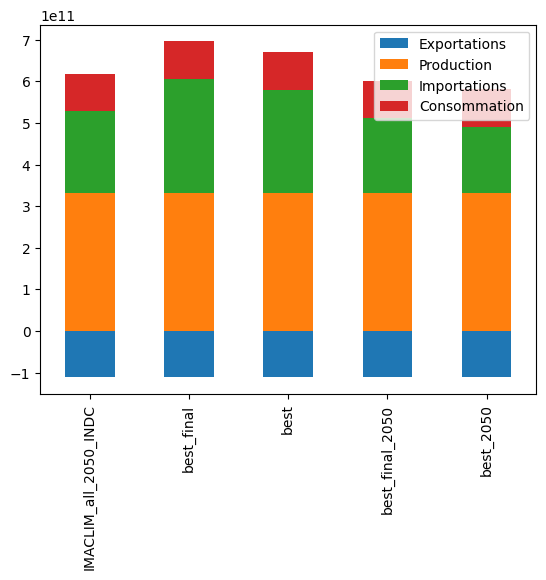

In [18]:

pd.concat([pd.Series(footprint_extractor(model.counterfactuals[counterfactual],"FR")) for counterfactual in model.get_counterfactuals_list() if counterfactual!='IMACLIM_all_prod_change_2050_INDC'],axis=1,keys=model.get_counterfactuals_list()).T.plot(kind="bar",stacked=True)



In [19]:
import plotly.express as px
data=pd.concat([pd.Series(footprint_extractor(model.counterfactuals[counterfactual],"FR")) for counterfactual in model.get_counterfactuals_list() if counterfactual!='IMACLIM_all_prod_change_2050_INDC'],axis=1,keys=model.get_counterfactuals_list())
px.bar(data.T,color_discrete_sequence=px.colors.qualitative.D3)


### Sensitivity analysis of CoefRow change based on final demands 

In [65]:
iot=model.counterfactuals["IMACLIM_emissi_2050_INDC2030_1000"].iot
CoefRoW=get_import_mean_stressor(iot,"FR")
temp_iot=iot.copy()
res=[]
for index in tqdm.tqdm(iot.Y.index):
    temp_Y=iot.Y.copy()
    temp_Y.loc[index,("United States","Final consumption expenditure by households")]+=temp_Y.loc[index].sum()*1
    temp_iot.reset_to_coefficients()
    temp_iot.Y=temp_Y
    temp_iot.calc_all()
    res.append(((get_import_mean_stressor(temp_iot,"FR")-CoefRoW)/CoefRoW))
    

100%|██████████| 3773/3773 [21:02<00:00,  2.99it/s]


In [66]:
res_df=pd.DataFrame(res,index=iot.Y.index)
res_df_fr=res_df.copy()
res_df_fr.loc["FR"]=0
pd.DataFrame([res_df.max(axis=0).loc["CO2"],res_df_fr.max(axis=0).loc["CO2"]],index=["with FR","without FR"])


sector,Air_transport,Aluminium_ores,Animal_Products,Biofuels,Biogas,Chemicals,Clothing_Industry,Coal,Coal-fired_electricity,Computers_communication_equipments,...,Secondary_Other_metals,Secondary_Plastics,Secondary_Pulp_and_paper,Secondary_Steel_iron,Secondary_Wood,Stone,Vegetable_Products,Water_Other_waste_Treatment,Water_transport,Wood_Waste_incineration
with FR,3.531583e-16,1.544184e-14,0.003664,0.000689,2.580279e-14,0.001889,0.004631,0.031327,2.297564e-16,0.00024,...,NaN,NaN,NaN,NaN,NaN,2.307280e-14,0.005223,0.000021,0.000085,9.326421e-15
without FR,3.531583e-16,2.394083e-16,0.000175,0.000076,3.794528e-16,0.000051,0.000147,0.000190,2.297564e-16,0.00001,...,0.0,0.0,0.0,0.0,0.0,6.469008e-16,0.000254,0.000001,0.000002,4.974091e-16


In [68]:
pd.DataFrame([res_df.max(axis=0).loc["CO2"],res_df_fr.max(axis=0).loc["CO2"]],index=["with FR","without FR"]).max(axis=1)


with FR       0.031327
without FR    0.000523
dtype: float64

### Producing CoefRoW excels

In [9]:
SRIO_hyb=pd.read_excel("../Data/MatMat/SRIO_FR 2015.xlsx",sheet_name="hybride",header=[0,1,2],index_col=[0,1,2,3])
SRIO_monetaire=pd.read_excel("../Data/MatMat/SRIO_FR 2015.xlsx",sheet_name="monetaire",header=[0,1,2],index_col=[0,1,2,3])

In [10]:
X_hyb=SRIO_hyb.loc[:,(slice(None),slice(None),"x")]
X_monetaire=SRIO_monetaire.loc[:,(slice(None),slice(None),"x")]

In [11]:
Transition_hybride_monetaire_RoW=(X_monetaire/X_hyb).fillna(0).loc["RoW"]
Transition_hybride_monetaire_RoW=Transition_hybride_monetaire_RoW.reset_index(["category","sub_category"])[("Supply","Supply","x")].fillna(0)

In [15]:
((get_import_mean_stressor(model.iot,"FR").loc[GHG_STRESSOR_NAMES].groupby("sector").sum().reindex(model.agg_sectors)/1e9)*Transition_hybride_monetaire_RoW).to_excel("../Outputs/coefrow_two_regions.xlsx")

In [16]:
((get_import_mean_stressor(model.counterfactuals['IMACLIM_all_2050_INDC'].iot,"FR").loc[GHG_STRESSOR_NAMES].groupby("sector").sum().reindex(model.agg_sectors)/1e9)*Transition_hybride_monetaire_RoW).to_excel("../Outputs/coefrow_INDC_2050_two_regions.xlsx")

### Tests

#### Order of emissiv and changes

In [4]:
CoefRoW=get_import_mean_stressor(model.iot,"FR").loc[GHG_STRESSOR_NAMES].groupby("sector").sum()
most_emissiv_sector=CoefRoW.sort_values(ascending=False).index[:4]
CoefRoW.sort_values(ascending=False)[:15]

/home/ubuntu/miniforge3/envs/MatMat-Trade-env/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


sector
Precious metal ores and concentrates    4.656264e+07
Coal-fired_electricity                  1.843229e+07
Landfill                                9.638387e+06
Electricity_by_gas                      8.504626e+06
Paddy rice                              6.044988e+06
Coal                                    5.066480e+06
Electricity_by_petroleum                4.769860e+06
Crude_coal                              4.681036e+06
Farm_animals                            4.058024e+06
Aluminium_ores                          4.028164e+06
Other_metal_ores                        3.948421e+06
Plant-based fibers                      3.832473e+06
Other_electricity                       3.702728e+06
Primary_Cement_lime_plaster             3.690106e+06
Wheat                                   3.062824e+06
dtype: float64

In [21]:
total_imports=get_total_imports_region(model.iot,"FR")
Emissions=(get_import_mean_stressor(model.iot,"FR").loc[GHG_STRESSOR_NAMES].sum()*total_imports).groupby("sector").sum()
most_emission_sector=Emissions.sort_values(ascending=False).index[:4]
Emissions.sort_values(ascending=False)[:15]

sector
Other_Business_Services               1.498573e+13
Machinery                             1.466061e+13
Motor_vehicles                        8.962822e+12
Hotel_Restaurant                      6.594022e+12
Clothing_Industry                     5.598620e+12
Oth_transport_equipment               5.308943e+12
Vegetable_Products                    4.983191e+12
Chemicals                             4.858795e+12
Computers_communication_equipments    4.457320e+12
Primary_Plastics                      4.203849e+12
Other_manufacturing_industry          3.899185e+12
Other land transport                  3.575080e+12
Metal_Product                         3.139865e+12
Crude_oil                             2.312503e+12
Air_transport                         2.187181e+12
dtype: float64

In [22]:
Emissions.sort_values(ascending=False)[15:30]

sector
Motor_fuels                2.171696e+12
Real estate                1.943196e+12
Water_transport            1.814334e+12
Primary_Steel_iron         1.793275e+12
Animal_Products            1.689575e+12
Primary_Pulp_and_paper     1.467177e+12
Vegetables, fruit, nuts    1.376577e+12
Commerce                   1.239122e+12
Natural_gas                1.233961e+12
Rail_transport             9.450206e+11
Primary_Aluminium          8.483906e+11
Primary_Wood               7.830003e+11
Public_Services            7.604637e+11
Construction               7.081208e+11
Dairy Products             6.594794e+11
dtype: float64

#### Graphs

In [7]:
plot_sector_import_distrib_full(model,["Motor_vehicles","Machinery","Oth_transport_equipment","Other_manufacturing_industry","Clothing_Industry"],scenarios=["base","best_final","best"])
plot_sector_import_distrib_full(model,["Motor_vehicles","Machinery","Oth_transport_equipment","Other_manufacturing_industry","Clothing_Industry"],scenarios=["base","IMACLIM_all_2050_INDC","best_2050"])

/home/ubuntu/miniforge3/envs/MatMat-Trade-env/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [8]:
plot_sector_import_distrib_full(model,["Water_transport","Rail_transport","Air_transport","Other land transport"],scenarios=["base","best_final","best"])
plot_sector_import_distrib_full(model,["Water_transport","Rail_transport","Air_transport","Other land transport"],scenarios=["base","IMACLIM_all_2050_INDC","best_2050"])

In [23]:
plot_sector_import_distrib_full(model,["Computers_communication_equipments","Hotel_Restaurant","Air_transport","Other land transport"],scenarios=["base","best_final","best"])
plot_sector_import_distrib_full(model,["Computers_communication_equipments","Hotel_Restaurant","Air_transport","Other land transport"],scenarios=["base","IMACLIM_all_2050_INDC","best_2050"])

In [10]:
plot_sector_import_distrib_full(model,["Chemicals","Primary_Plastics"],scenarios=["base","best_final","best"])
plot_sector_import_distrib_full(model,["Chemicals","Primary_Plastics"],scenarios=["base","IMACLIM_all_2050_INDC","best_2050"])

In [11]:
plot_sector_import_distrib_full(model,["Primary_Steel_iron","Metal_Product","Primary_Aluminium"],scenarios=["base","best_final","best"])
plot_sector_import_distrib_full(model,["Primary_Steel_iron","Metal_Product","Primary_Aluminium"],scenarios=["base","IMACLIM_all_2050_INDC","best_2050"])

In [12]:
plot_sector_import_distrib_full(model,["Vegetable_Products","Animal_Products","Vegetables, fruit, nuts","Dairy Products"],scenarios=["base","best_final","best"])
plot_sector_import_distrib_full(model,["Vegetable_Products","Animal_Products","Vegetables, fruit, nuts","Dairy Products"],scenarios=["base","IMACLIM_all_2050_INDC","best_2050"])

In [28]:
plot_sector_import_distrib_full(model,["Clothing_Industry","Other_manufacturing_industry","Real estate","Machinery"],scenarios=["base","best_final","best"])
plot_sector_import_distrib_full(model,["Clothing_Industry","Other_manufacturing_industry","Real estate","Machinery"],scenarios=["base","IMACLIM_all_2050_INDC","best_2050"])

In [29]:
plot_sector_import_distrib_full(model,["Clothing_Industry","Other_manufacturing_industry","Real estate","Construction"],scenarios=["base","best_final","best"])
plot_sector_import_distrib_full(model,["Clothing_Industry","Other_manufacturing_industry","Real estate","Construction"],scenarios=["base","IMACLIM_all_2050_INDC","best_2050"])

/home/ubuntu/miniforge3/envs/MatMat-Trade-env/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [8]:
model.counterfactuals["IMACLIM_all_2050_INDC"].iot.stressor_extension.M.loc[MATERIAL_STRESSOR_NAMES].sum()

region           sector                     
Austria          Air_transport                  0.132225
                 Aluminium_ores                 0.000000
                 Animal_Products                0.265966
                 Biofuels                       0.756441
                 Biogas                         0.567783
                                                  ...   
RoW Middle East  Vegetables, fruit, nuts        0.148262
                 Water_Other_waste_Treatment    0.689517
                 Water_transport                0.461117
                 Wheat                          0.418183
                 Wood_Waste_incineration        0.776573
Length: 4263, dtype: float64

### Adjusting final demand according to the SRIO

In [19]:
SRIO_demand=SRIO_monetaire["FD"].drop("Exports",level=0,axis=1).sum(axis=1)["FR"].reset_index([0,1])[0]
SRIO_final_import=SRIO_monetaire["FD"].drop("Exports",level=0,axis=1).sum(axis=1)["RoW"].reset_index([0,1])[0]
SRIO_final_exports=SRIO_monetaire["FD","Exports"].loc["FR"].reset_index([0,1])["E"]

In [20]:
iot_bis=bis=model.iot.copy()

In [21]:
for column in iot_bis.Y.loc["FR","FR"].columns:
    iot_bis.Y.loc[("FR",slice(None)),("FR",column)]=iot_bis.Y.loc[("FR",slice(None)),("FR",column)]*(pd.DataFrame(SRIO_demand).T/iot_bis.Y.loc["FR","FR"].sum(axis=1)).loc[0]


ratio_final_imports=(pd.DataFrame(SRIO_final_import).T/iot_bis.Y.drop("FR",axis=0,level=0).loc[:,"FR"].sum(axis=0,level=1).sum(axis=1)).loc[0]
for region in iot_bis.Y.drop("FR",axis=0,level=0).index.get_level_values("region").unique():
    for column in iot_bis.Y.loc[region,"FR"].columns:
        iot_bis.Y.loc[(region,slice(None)),("FR",column)]=iot_bis.Y.loc[(region,slice(None)),("FR",column)]*ratio_final_imports
   
   
ratio_final_exports=SRIO_final_exports/iot_bis.Y.loc["FR",:].drop("FR",axis=1).sum(axis=1)
for region in iot_bis.Y.drop("FR",axis=1).columns.get_level_values("region").unique():
    for column in iot_bis.Y.loc["FR",region].columns:
        iot_bis.Y.loc[("FR",slice(None)),(region,column)]=iot_bis.Y.loc[("FR",slice(None)),(region,column)]*ratio_final_exports

iot_bis.Y.fillna(0,inplace=True)

In [22]:
(pd.DataFrame(SRIO_demand).T/iot_bis.Y.loc["FR","FR"].sum(axis=1)).loc[0]

sector
Paddy rice                 1.004782
Wheat                      0.955358
Cereal grains nec          0.834480
Vegetables, fruit, nuts    1.004808
Oil seeds                  0.957838
                             ...   
Real estate                0.993670
Hotel_Restaurant           0.998498
Commerce                   0.820795
Other_Business_Services    0.984410
Public_Services            1.024126
Name: 0, Length: 87, dtype: float64

In [23]:
(pd.DataFrame(SRIO_final_import).T/iot_bis.Y.drop("FR",axis=0,level=0).loc[:,"FR"].sum(axis=0,level=1).sum(axis=1)).loc[0]

sector
Paddy rice                 1.0
Wheat                      1.0
Cereal grains nec          1.0
Vegetables, fruit, nuts    1.0
Oil seeds                  1.0
                          ... 
Real estate                NaN
Hotel_Restaurant           NaN
Commerce                   1.0
Other_Business_Services    1.0
Public_Services            1.0
Name: 0, Length: 87, dtype: float64

In [24]:
SRIO_final_exports/iot_bis.Y.loc["FR",:].drop("FR",axis=1).sum(axis=1)

sector
Paddy rice                 1.0
Wheat                      1.0
Cereal grains nec          1.0
Vegetables, fruit, nuts    1.0
Oil seeds                  1.0
                          ... 
Real estate                1.0
Hotel_Restaurant           1.0
Commerce                   1.0
Other_Business_Services    1.0
Public_Services            1.0
Length: 87, dtype: float64

In [25]:
iot_bis.stressor_extension=recal_stressor_per_region(iot_bis,recalc_F_Y=True)

In [24]:
total_imports=get_total_imports_region(iot_bis,"FR")
D_imp_MatMat=(get_import_mean_stressor(iot_bis,"FR").loc[GHG_STRESSOR_NAMES].drop("CO2 - other",level=0).sum(level=1)*total_imports.groupby("sector").sum()).sum()/1e9
D_imp_pymrio=iot_bis.stressor_extension.D_imp["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9
CF=iot_bis.stressor_extension.D_cba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9+iot_bis.stressor_extension.F_Y["FR"].drop("CO2 - other").sum().sum()/1e9
D_cba=iot_bis.stressor_extension.D_cba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9
D_pba=iot_bis.stressor_extension.D_pba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9
D_exp=iot_bis.stressor_extension.D_exp["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9

print("D_imp_MatMat: {} \nD_imp_pymrio : {} \nCF : {} \nD_cba : {} \nD_pba : {} \nD_exp : {} ".format(D_imp_MatMat,D_imp_pymrio,CF,D_cba,D_pba,D_exp))

D_imp_MatMat: 448.0467724768476 
D_imp_pymrio : 298.24969679499657 
CF : 602.6985673688774 
D_cba : 517.3513423974721 
D_pba : 401.1214841230803 
D_exp : 182.01983852060476 


In [14]:
iot_bis=model.iot.copy()
total_imports=get_total_imports_region(iot_bis,"FR")
D_imp_MatMat=(get_import_mean_stressor(iot_bis,"FR").loc[GHG_STRESSOR_NAMES].drop("CO2 - other",level=0).sum(level=1)*total_imports.groupby("sector").sum()).sum()/1e9
D_imp_pymrio=iot_bis.stressor_extension.D_imp["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9
CF=iot_bis.stressor_extension.D_cba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9+iot_bis.stressor_extension.F_Y["FR"].drop("CO2 - other").sum().sum()/1e9
D_cba=iot_bis.stressor_extension.D_cba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9
D_pba=iot_bis.stressor_extension.D_pba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9
D_exp=iot_bis.stressor_extension.D_exp["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9

print("D_imp_MatMat: {} \nD_imp_pymrio : {} \nCF : {} \nD_cba : {} \nD_pba : {} \nD_exp : {} ".format(D_imp_MatMat,D_imp_pymrio,CF,D_cba,D_pba,D_exp))

D_imp_MatMat: 413.914312839533 
D_imp_pymrio : 316.46089296038184 
CF : 633.4949469386554 
D_cba : 543.6205815406418 
D_pba : 347.8413449035042 
D_exp : 120.68165632325822 


In [20]:
iot_bis=model.iot.copy()
total_imports=get_total_imports_region(iot_bis,"FR")
D_imp_MatMat=(get_import_mean_stressor(iot_bis,"FR").loc[GHG_STRESSOR_NAMES].drop("CO2 - other",level=0).sum(level=1)*total_imports.groupby("sector").sum()).sum()/1e9
D_imp_pymrio=iot_bis.stressor_extension.D_imp["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9
CF=iot_bis.stressor_extension.D_cba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9+iot_bis.stressor_extension.F_Y["FR"].drop("CO2 - other").sum().sum()/1e9
D_cba=iot_bis.stressor_extension.D_cba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9
D_pba=iot_bis.stressor_extension.D_pba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9
D_exp=iot_bis.stressor_extension.D_exp["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9

print("D_imp_MatMat: {} \nD_imp_pymrio : {} \nCF : {} \nD_cba : {} \nD_pba : {} \nD_exp : {} ".format(D_imp_MatMat,D_imp_pymrio,CF,D_cba,D_pba,D_exp))

D_imp_MatMat: 370.15196735984273 
D_imp_pymrio : 286.6325181351243 
CF : 589.6575919159587 
D_cba : 499.78322651784606 
D_pba : 322.6812849946251 
D_exp : 109.53057661203519 


In [33]:
iot_bis=model.iot.copy()
total_imports=get_total_imports_region(iot_bis,"FR")
D_imp_MatMat=(get_import_mean_stressor(iot_bis,"FR").loc[GHG_STRESSOR_NAMES].sum(level=1)*total_imports.groupby("sector").sum()).sum()/1e9
D_imp_pymrio=iot_bis.stressor_extension.D_imp["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].sum().sum()/1e9
CF=iot_bis.stressor_extension.D_cba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].sum().sum()/1e9+iot_bis.stressor_extension.F_Y["FR"].sum().sum()/1e9
D_cba=iot_bis.stressor_extension.D_cba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].sum().sum()/1e9
D_pba=iot_bis.stressor_extension.D_pba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].sum().sum()/1e9
D_exp=iot_bis.stressor_extension.D_exp["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].sum().sum()/1e9

print("D_imp_MatMat: {} \nD_imp_pymrio : {} \nCF : {} \nD_cba : {} \nD_pba : {} \nD_exp : {} ".format(D_imp_MatMat,D_imp_pymrio,CF,D_cba,D_pba,D_exp))

D_imp_MatMat: 419.46772909576606 
D_imp_pymrio : 314.1562935966 
CF : 612.707840771093 
D_cba : 522.8334753729803 
D_pba : 322.6812793274116 
D_exp : 114.00409755119644 


D_imp_MatMat: 0.0005800103859243659 
D_imp_pymrio : 0.00040685047719812324 
CF : 89.87497268068161 
D_cba : 0.0006072825689586676 
D_pba : 0.0003450802053808304 
D_exp : 0.00014464811362079947 


In [57]:
multi_footprints_extractor(model.iot)

In [70]:
Model_name="MatMat_sectors_all_countries_with_capital"
save_footprints(model.iot,"../Outputs/Footprints/{}.xlsx".format(Model_name))


In [17]:
iot_bis=model.iot.copy()
total_imports=get_total_imports_region(iot_bis,"FR")
D_imp_MatMat=(get_import_mean_stressor(iot_bis,"FR").loc[GHG_STRESSOR_NAMES].drop("CO2 - other",level=0).sum(level=1)*total_imports.groupby("sector").sum()).sum()/1e9
D_imp_pymrio=iot_bis.stressor_extension.D_imp["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9
CF=iot_bis.stressor_extension.D_cba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9+iot_bis.stressor_extension.F_Y["FR"].drop("CO2 - other").sum().sum()/1e9
D_cba=iot_bis.stressor_extension.D_cba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9
D_pba=iot_bis.stressor_extension.D_pba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9
D_exp=iot_bis.stressor_extension.D_exp["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9

print("D_imp_MatMat: {} \nD_imp_pymrio : {} \nCF : {} \nD_cba : {} \nD_pba : {} \nD_exp : {} ".format(D_imp_MatMat,D_imp_pymrio,CF,D_cba,D_pba,D_exp))

D_imp_MatMat: 515.5834387887737 
D_imp_pymrio : 394.38371199956305 
CF : 710.4389393371265 
D_cba : 620.5645739391128 
D_pba : 347.8413449035119 
D_exp : 121.66048296395192 


In [26]:
total_imports=get_total_imports_region(iot_bis,"FR")
D_imp_MatMat=(get_import_mean_stressor(iot_bis,"FR").loc[GHG_STRESSOR_NAMES].drop("CO2 - other",level=0).sum(level=1)*total_imports.groupby("sector").sum()).sum()/1e9
D_imp_pymrio=iot_bis.stressor_extension.D_imp["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9
CF=iot_bis.stressor_extension.D_cba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9+iot_bis.stressor_extension.F_Y["FR"].drop("CO2 - other").sum().sum()/1e9
D_cba=iot_bis.stressor_extension.D_cba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9
D_pba=iot_bis.stressor_extension.D_pba["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9
D_exp=iot_bis.stressor_extension.D_exp["FR"].loc[(slice(None),GHG_STRESSOR_NAMES),:].drop("CO2 - other",level=1).sum().sum()/1e9

print("D_imp_MatMat: {} \nD_imp_pymrio : {} \nCF : {} \nD_cba : {} \nD_pba : {} \nD_exp : {} ".format(D_imp_MatMat,D_imp_pymrio,CF,D_cba,D_pba,D_exp))

D_imp_MatMat: 560.4471952347783 
D_imp_pymrio : 373.9559588891722 
CF : 677.4706160402103 
D_cba : 592.1233910688076 
D_pba : 401.04132899963986 
D_exp : 182.87389682000435 


In [29]:
A=pd.DataFrame(index=["GHG","MATERIAL"])

In [31]:
A["d_imp"]=[0,1]

In [32]:
A

,d_imp
GHG,0
MATERIAL,1


In [53]:
import pymrio 
from typing import List,Dict

def multi_footprints_extractor(iot: pymrio.IOSystem,region : str = "FR", stressor_lists : Dict ={"GHG":GHG_STRESSOR_NAMES,"MATERIAL":MATERIAL_STRESSOR_NAMES}):
    """Computes region's footprint indicators : D_imp, D_cba, D_pba,D_exp, Footprint for several groups of stressors. 

    Args:
        model (Union[Model, Counterfactual]): object Model or Counterfactual defined in model.py
        region (str, optional): region name. Defaults to "FR".
        stressor_lists (Dict[str:List[str]],optional) : list of the groups of the stressor to sum, default to the {"GHG":GHG_STRESSOR_NAMES,"MATERIAL":MATERIAL_STRESSOR_NAMES}.

    Returns:
        Dict: values of -D_exp, D_pba, D_imp and F_Y
    """
    
    Footprints=pd.DataFrame(index=["D_imp_MatMat","D_imp_pymrio","Footprint","D_cba","D_pba","D_exp"])# initialte empty datarframe
    total_imports=get_total_imports_region(iot,region)
    mean_stressors=get_import_mean_stressor(iot,region)
                                   
    for name,stressor_list in stressor_lists.items() :
        D_imp_MatMat=(mean_stressors.loc[stressor_list].sum(level=1)*total_imports.groupby("sector").sum()).sum()
        D_imp_pymrio=iot.stressor_extension.D_imp[region].loc[(slice(None),stressor_list),:].sum().sum()
        Footprint=iot.stressor_extension.D_cba[region].loc[(slice(None),stressor_list),:].sum().sum()+iot.stressor_extension.F_Y[region].sum().sum()
        D_cba=iot.stressor_extension.D_cba[region].loc[(slice(None),stressor_list),:].sum().sum()
        D_pba=iot.stressor_extension.D_pba[region].loc[(slice(None),stressor_list),:].sum().sum()
        D_exp=iot.stressor_extension.D_exp[region].loc[(slice(None),stressor_list),:].sum().sum()
        Footprints[name]=[D_imp_MatMat,D_imp_pymrio,Footprint,D_cba,D_pba,D_exp]
        
    return Footprints

In [69]:
def save_footprints(iot: pymrio.IOSystem,path:str,region : str = "FR", stressor_lists : Dict ={"GHG":GHG_STRESSOR_NAMES,"MATERIAL":MATERIAL_STRESSOR_NAMES}):
    Footprints=multi_footprints_extractor(iot,region=region, stressor_lists=stressor_lists)
    
    with pd.ExcelWriter(path) as writer:
        Footprints.to_excel(writer,sheet_name="Footprints",index=False)
        pd.DataFrame.from_dict(stressor_lists,orient='index').T.to_excel(writer,sheet_name="Stressor_groups",index=False)